
<h1><center>Análisis de propinas en los taxi de NY</center></h1>


Tenemos un cliente que se quiere expandir en NY y necesita diseñar un modelo predictivo para incluir en la app para sugerir la propina a dar al finalizar el trayecto. 
Dado que no tiene datos propios recogidos por el momento se realizará un análisis y modelo con los datos de los taxis de amarillos de NY. 
Primeramente bajamos los datos de la web. 

## Preparación del entorno

Carga de librerías necesarias.

In [1]:
#Carga de libreria necesarias para el ejercicio
library(sparklyr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(dbplot)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



ERROR: Error in library(dbplot): there is no package called 'dbplot'


Configuración entorno Spark

In [2]:
#conexión a spark
sc <- spark_connect(master = "local")
spark_web(sc)
#spark_disconnect(sc)

Registered S3 method overwritten by 'openssl':
  method      from
  print.bytes Rcpp


In [ ]:
#spark_disconnect(sc)

## Carga de datos

Hacemos una primera revisión rápida de los datos y verificar los tipos de datos para su posterior utilización. 


In [3]:
Top100Datos<-read.csv("C:/Users/Sara/Desktop/DatosTaxi/yellow_tripdata_2017-03.csv", nrows = 100)
glimpse(Top100Datos)

Observations: 100
Variables: 17
$ VendorID              <int> 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...
$ tpep_pickup_datetime  <fct> 2017-03-09 21:30:11, 2017-03-09 21:47:00, 201...
$ tpep_dropoff_datetime <fct> 2017-03-09 21:44:20, 2017-03-09 21:58:01, 201...
$ passenger_count       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 5, ...
$ trip_distance         <dbl> 4.06, 2.73, 2.27, 3.86, 3.45, 2.80, 6.00, 8.7...
$ RatecodeID            <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ store_and_fwd_flag    <fct> N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...
$ PULocationID          <int> 148, 48, 79, 237, 41, 261, 87, 142, 68, 261, ...
$ DOLocationID          <int> 48, 107, 162, 41, 162, 79, 142, 181, 141, 163...
$ payment_type          <int> 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ fare_amount           <dbl> 14.0, 11.5, 10.0, 12.0, 12.0, 12.5, 19.5, 30....
$ extra                 <dbl> 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...
$ mta_tax           

Cambio algunos de los tipos de datos que aparecen por defecto para poder operar con esas variables después.

In [4]:
#Defino el schema de los datos 
schema_final <- c( VendorID   = "integer", tpep_pickup_datetime  = "timestamp", tpep_dropoff_datetime="timestamp", passenger_count="integer",
                     trip_distance="numeric", RatecodeID="factor",store_and_fwd_flag="character",PULocationID="character",DOLocationID="character",
                     payment_type="factor",fare_amount="numeric",extra="numeric", mta_tax="numeric", tip_amount="numeric",tolls_amount="integer",
                     improvement_surcharge="numeric",total_amount="numeric") 
#Cargo los datos
DataTaxi<-spark_read_csv(sc, "C:/Users/Sara/Desktop/DatosTaxi/", columns = schema_final, infer_schema=FALSE)

Realizo el conteo de los datos y reviso que se han modificado los tipos de datos como se requería. 

In [5]:
#cuento los registros
count(DataTaxi)
#reviso los datos 
glimpse(DataTaxi)

# Source: spark<?> [?? x 1]
         n
     <dbl>
1 29720436

Observations: ??
Variables: 17
Database: spark_connection
$ VendorID              <int> 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, ...
$ tpep_pickup_datetime  <dttm> 2017-03-09 20:30:11, 2017-03-09 20:47:00, 20...
$ tpep_dropoff_datetime <dttm> 2017-03-09 20:44:20, 2017-03-09 20:58:01, 20...
$ passenger_count       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 5, ...
$ trip_distance         <dbl> 4.06, 2.73, 2.27, 3.86, 3.45, 2.80, 6.00, 8.7...
$ RatecodeID            <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1", ...
$ store_and_fwd_flag    <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", ...
$ PULocationID          <chr> "148", "48", "79", "237", "41", "261", "87", ...
$ DOLocationID          <chr> "48", "107", "162", "41", "162", "79", "142",...
$ payment_type          <chr> "1", "2", "1", "1", "2", "1", "1", "1", "1", ...
$ fare_amount           <dbl> 14.0, 11.5, 10.0, 12.0, 12.0, 12.5, 19.5, 30....
$ extra                 <dbl> 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

Como se quiere calcular la propina a sugerir, se eliminarán aquellos registros que no la tengan registrada por el tipo de pago. No puedo eliminar todos los registros ya que habrá gente que haya decidido no dar propina. 

Analizamos la propina por tipo de pago, ya que en el diseño de registro se indica que no se registran propinas en metálico, también parece lógico eliminar aquellos viajes que sean del tipo "No charge", "Dispute", "Unknown" y "Voided trip". 


In [6]:
DataTaxiTarjeta<-DataTaxi %>%
                    filter(payment_type==1)
count(DataTaxiTarjeta)

# Source: spark<?> [?? x 1]
         n
     <dbl>
1 18937135

## Análisis explotario de datos 

Calculamos los estadísticos básicos de las variables continuas. 

In [7]:
Summary1<-sdf_describe(DataTaxiTarjeta,c("passenger_count","trip_distance","fare_amount","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount"))
as.data.frame(Summary1)


summary,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,18937135,18937135,18937135,18937135,18937135,18937135,18937135,18937135,18937135
mean,1.6038310441362962,2.464552778971072,11.814522147621616,0.3368190489216029,0.4987931363429576,2.3701330882423917,0.008807298464102411,0.2999180974259983,15.334558944174981
stddev,1.2558351805466668,2.7144820158183993,9.005785215001747,0.3960646888497585,0.09637288483712515,2.115569998767731,0.42893715689781786,0.005125913384657877,10.605803184812585
min,0,0.0,-52.0,-38.6,-0.5,-15.84,0,-0.3,-70.59
max,9,598.5,852.5,96.0,250.0,444.5,288,1.0,852.5


In [8]:
vars<-c("passenger_count","trip_distance","fare_amount","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount")
q<-data.frame(matrix(ncol = 0, nrow = 5))
for(var in vars)
    { 
        a<-as.data.frame(sdf_quantile(DataTaxiTarjeta,var,probabilities = c( 0.25, 0.5, 0.75,0.95,0.99)))
        q<-cbind(q,a)
}
names(q)<-vars
q


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
25%,1,1.00,6.5,0.0,0.5,1.26,0,0.3,9.35
50%,1,1.62,9.5,0.0,0.5,2.00,0,0.3,12.36
75%,2,2.80,14.0,0.5,0.5,2.86,0,0.3,17.76
95%,5,7.20,27.0,1.0,0.5,5.45,0,0.3,32.85
99%,6,15.60,52.0,1.0,0.5,10.15,0,0.3,60.80


De los importes extra que se cobran verifico que están todos dentro de los rangos especificados para filtrarlos en otro caso, de no ser así filtraré aquellos registros. 

In [9]:
DataTaxiTarjeta %>%
         group_by(extra) %>%
         summarize( count=n()) %>%
        arrange(desc(count))


DataTaxiTarjeta %>%
         group_by(mta_tax) %>%
         summarize( count=n()) %>%
        arrange(desc(count))

DataTaxiTarjeta %>%
         group_by(Improvement_surcharge) %>%
         summarize( count=n()) %>%
        arrange(desc(count))
DataTaxiTarjeta %>%
         group_by(tolls_amount) %>%
         summarize( count=n()) %>%
        arrange(desc(count))


# Source:     spark<?> [?? x 2]
# Ordered by: desc(count)
   extra   count
   <dbl>   <dbl>
 1  0    9484443
 2  0.5  6281603
 3  1    3152014
 4  4.5    18970
 5  0.02      20
 6  1.5       15
 7  0.3       13
 8  4.54       9
 9  0.1        8
10  0.2        6
# ... with more rows

# Source:     spark<?> [?? x 2]
# Ordered by: desc(count)
   mta_tax    count
     <dbl>    <dbl>
 1    0.5  18887724
 2    0       48672
 3    0.85      652
 4    3          45
 5    0.25       10
 6   -0.5         5
 7    7.68        3
 8    0.37        3
 9    0.35        1
10   10.3         1
# ... with more rows

# Source:     spark<?> [?? x 2]
# Ordered by: desc(count)
  Improvement_surcharge    count
                  <dbl>    <dbl>
1                   0.3 18931820
2                   0       5265
3                   1         45
4                  -0.3        5

# Source:     spark<?> [?? x 2]
# Ordered by: desc(count)
   tolls_amount    count
          <int>    <dbl>
 1            0 18926438
 2           15     1285
 3           18     1118
 4            8      949
 5           17      927
 6           21      849
 7            6      831
 8           16      830
 9           20      623
10           25      588
# ... with more rows

Una vez realizado el primer análisis exploratorio de los datos, a continuación se filtran los datos para eliminar datos atípicos y erróneos y generar nuevas variables: 

1. Filtramos aquellos registros que contienen valores erróneos en las variables "extra", "mta_tax", "improvement_surchage"
2. Filtramos aquellos registros con outlier en las variables continuas 
3. Cálculamos nuevas variables que pueden resultar de interés para la modelización: 
    - WeekDay: día de la semana en la que comienza el viaje
    - TripDurationMin: duración del viaje en minutos 
    - Tipo de horario: esta variable se deriva de la variable "extra" 
    - ZoneChange: cambio de zona 
    - AvgSpeed: velocidad media del viaje millas/hora
    


In [10]:
#Defino el schema de los datos 
schema_final <- c( VendorID   = "integer", tpep_pickup_datetime  = "timestamp", tpep_dropoff_datetime="timestamp", passenger_count="integer",
                     trip_distance="numeric", RatecodeID="factor",store_and_fwd_flag="character",PULocationID="character",DOLocationID="character",
                     payment_type="factor",fare_amount="numeric",extra="numeric", mta_tax="numeric", tip_amount="numeric",tolls_amount="integer",
                     improvement_surcharge="numeric",total_amount="numeric") 
#Cargo los datos
DataTaxiTarjetaFiltrado<-DataTaxiTarjeta %>%
            filter(tip_amount>=0 && tip_amount<=50) %>%
            filter(extra==0 || extra==0.5 || extra==1) %>%
            filter(mta_tax==0.5) %>% 
            filter(Improvement_surcharge==0.3 ) %>% 
            mutate(WeekDay=dayofweek(tpep_dropoff_datetime)) %>%
            mutate(TripDurationMin=(bigint(to_timestamp(tpep_dropoff_datetime)) - bigint(to_timestamp(tpep_pickup_datetime)))/60 ) %>%
            filter(TripDurationMin>0 && trip_distance>0 ) %>% 
            filter(trip_distance<=15.60)%>%
            filter(fare_amount<=52)%>%
            filter(tip_amount<=10.15)%>%
            mutate(TypeTripHour=ifelse(extra==0,'Normal', ifelse(extra==0.5,'Rush Hour', 'OverNight'))) %>%
            mutate(ZoneChange=ifelse(PULocationID ==DOLocationID ,'N', 'Y')) %>%
            mutate(AvgSpeed=trip_distance/(TripDurationMin/60)) %>%
            select(passenger_count,trip_distance,RatecodeID,fare_amount, tip_amount,tolls_amount,WeekDay,AvgSpeed,TripDurationMin,TypeTripHour, ZoneChange)

       

Conteo de datos. 

In [11]:
count(DataTaxiTarjetaFiltrado)

# Source: spark<?> [?? x 1]
         n
     <dbl>
1 18606021

In [19]:
glimpse(DataTaxiTarjetaFiltrado)

Observations: ??
Variables: 11
Database: spark_connection
$ passenger_count <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 1, ...
$ trip_distance   <dbl> 4.06, 2.27, 3.86, 2.80, 6.00, 8.70, 3.70, 4.21, 2.0...
$ RatecodeID      <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "...
$ fare_amount     <dbl> 14.0, 10.0, 12.0, 12.5, 19.5, 30.0, 16.5, 20.5, 8.5...
$ tip_amount      <dbl> 3.06, 2.82, 3.99, 1.00, 3.50, 7.80, 1.50, 4.26, 1.9...
$ tolls_amount    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ WeekDay         <int> 5, 5, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...
$ AvgSpeed        <dbl> 17.2155477, 13.4407899, 0.4725566, 11.6937352, 18.4...
$ TripDurationMin <dbl> 14.150000, 10.133333, 490.100000, 14.366667, 19.500...
$ TypeTripHour    <chr> "Rush Hour", "Rush Hour", "Rush Hour", "Rush Hour",...
$ ZoneChange      <chr> "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "Y", "...


## Análisis univariante

### passenger_count 

In [12]:
options(repr.plot.width=3, repr.plot.height=3)

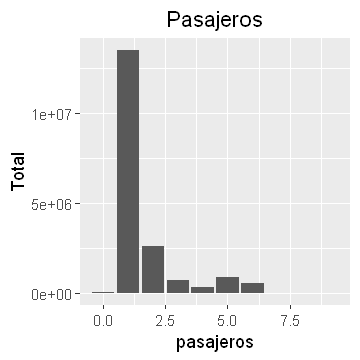

In [20]:
DataTaxiTarjetaFiltrado %>% 
    group_by(passenger_count ) %>%
    summarise(count=n()) %>%
    collect()  %>%
    ggplot() +
    geom_col(aes(passenger_count , count))+
  ggtitle("Pasajeros") +
  xlab("pasajeros") + ylab("Total")+
  theme(plot.title = element_text(hjust = 0.5))

### RateCodeID

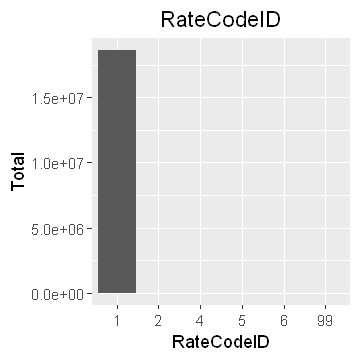

In [21]:
DataTaxiTarjetaFiltrado %>% 
    group_by(RatecodeID       ) %>%
    summarise(count=n()) %>%
    collect()  %>%
    ggplot() +
    geom_col(aes(RatecodeID, count))+  
    ggtitle("RateCodeID") +
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("RateCodeID") + ylab("Total")

### Week day

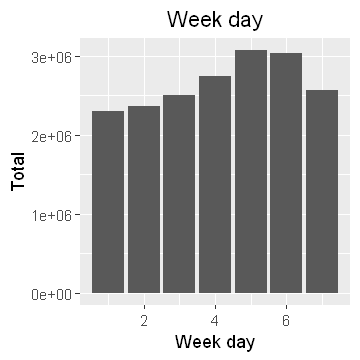

In [22]:
DataTaxiTarjetaFiltrado %>% 
    group_by(WeekDay) %>%
    summarise(count=n()) %>%
    collect()  %>%
    ggplot() +
    geom_col(aes(WeekDay, count))+  
    ggtitle("Week day") +
  theme(plot.title = element_text(hjust = 0.5))+
  xlab("Week day") + ylab("Total")

### TypeTripHour 

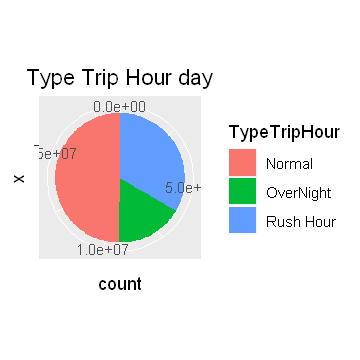

In [25]:
DataTaxiTarjetaFiltrado %>% 
    group_by(TypeTripHour) %>%
    summarise(count=n()) %>%
    collect()  %>%
    ggplot() +
    geom_col(aes(x="", y=count, fill=TypeTripHour))+ coord_polar(theta = "y")+  
    ggtitle("Type Trip Hour day") +
  theme(plot.title = element_text(hjust = 0.5))

### ZoneChange 

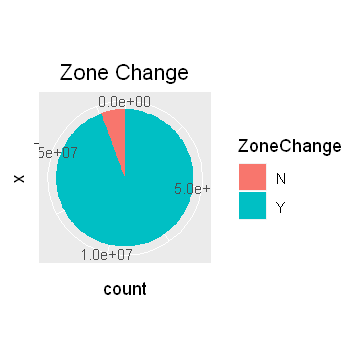

In [28]:
DataTaxiTarjetaFiltrado %>% 
    group_by(ZoneChange) %>%
    summarise(count=n()) %>%
    collect()  %>%
    ggplot() +
    geom_col(aes(x="", y=count, fill=ZoneChange))+ coord_polar(theta = "y")+
     ggtitle("Zone Change") +
  theme(plot.title = element_text(hjust = 0.5))


### trip_distance 

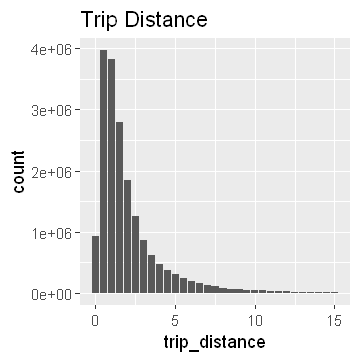

In [31]:
DataTaxiTarjetaFiltrado %>% 
dbplot_histogram(trip_distance, binwidth = 0.5) +
labs(title = "Trip Distance")

### AvgSpeed

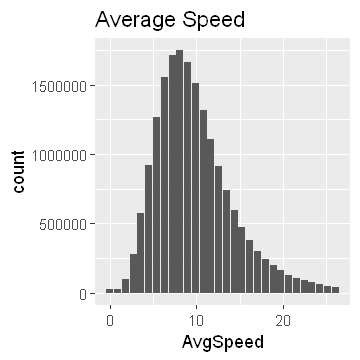

In [37]:
DataTaxiTarjetaFiltrado %>% 
    filter(AvgSpeed<=26.959538)%>%
dbplot_histogram(AvgSpeed) +
labs(title = "Average Speed")

## Correlaciones

In [38]:
install.packages("corrplot")


  There is a binary version available but the source version is later:
         binary source needs_compilation
corrplot   0.88   0.92             FALSE



installing the source package 'corrplot'



In [39]:
library(corrplot)

corrplot 0.92 loaded


In [40]:

mat=ml_corr(DataTaxiTarjetaFiltrado, columns = c("trip_distance","fare_amount","TripDurationMin","AvgSpeed","tip_amount"), method = "pearson")

mat<-as.matrix(mat)

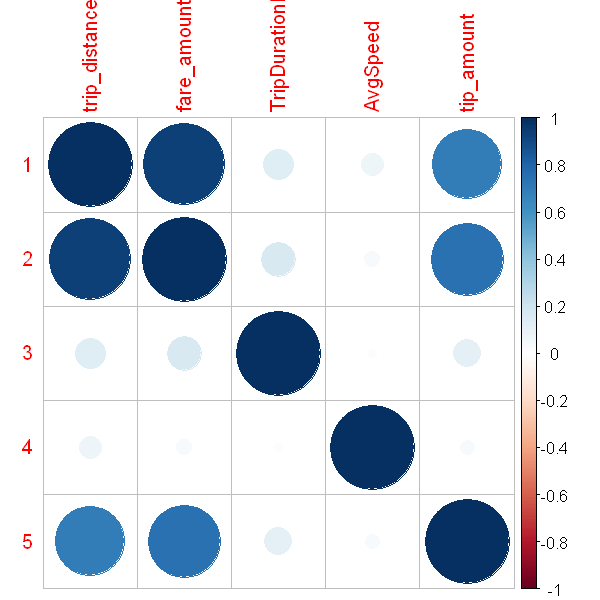

In [42]:
options(repr.plot.width=5, repr.plot.height=5)
corrplot(mat)

# Conclusiones

Una vez realizado el análisis de los datos, se ha procedido a realizar los filtros correspondientes eliminando aquellos datos erróneos y con datos atípicos. Dado el elevado número de registros de los que disponemos no supone a priori ningún problema, si no podríamos haberlos corregido o imputado. 
Entre las variables disponibles, desechamos aquellas que no van a aportar en principio nada al modelo, por tener no tener variabilidad en los valores como por ejemplo RateCodeId o no tener sentido incluirla como VendorID. 
Además tampoco incluiremos en la fórmula de nuestros módelos la variable total_amount por se combinación lineal de las variables que incluyen todos los importes y tarifas y la variable trip_distance por la alta correlación que presenta con la variable fare_amount. 